In [1]:
import chex

chex.set_n_cpu_devices(4)

from functools import partial
import os
from pathlib import Path
import pickle
from typing import Literal, NamedTuple

from gabenet.mcmc import sample_markov_chain
from gabenet.nets import MultinomialDirichletBelieve, PoissonGammaBelieve
from gabenet.utils import freeze_trainable_states, perplexity
import haiku as hk
import jax
from jax import random
import jax.numpy as jnp
from scipy.stats import entropy

import sys
sys.path.append(str(Path('examples/mutational-signatures/').resolve()))
from dataset import load_mutation_spectrum, COSMIC_WEIGHTS


2023-08-30 16:26:20.313790: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Model hyperparameters.
MODEL: Literal[
    "multinomial_dirichlet_believe", "poisson_gamma_believe"
] = "multinomial_dirichlet_believe"
n_topics = len(COSMIC_WEIGHTS)
HIDDEN_LAYER_SIZES = [n_topics]
GAMMA_0 = 10.0
_bottom_layer_name = (
    f"{MODEL}/~/multinomial_layer"
    if MODEL == "multinomial_dirichlet_believe"
    else f"{MODEL}/~/poisson_layer"
)
# Print out model hyperparameters for logging.
print(f"MODEL = {MODEL}")
print(f"n_topics = {n_topics}")
print(f"HIDDEN_LAYER_SIZES = {HIDDEN_LAYER_SIZES}")
print(f"GAMMA_0 = {GAMMA_0}")

n_features = 96
X_train, X_test = load_mutation_spectrum()
X_train = X_train[:5]
X_test = X_test[:5]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


MODEL = multinomial_dirichlet_believe
n_topics = 78
HIDDEN_LAYER_SIZES = [78]
GAMMA_0 = 10.0


In [3]:
@hk.transform_with_state
def kernel(X=X_train, freeze_phi=True):
    """Advance the Markov chain by one step."""
    if MODEL == "multinomial_dirichlet_believe":
        model = MultinomialDirichletBelieve(
            HIDDEN_LAYER_SIZES, n_features, gamma_0=GAMMA_0
        )
    else:
        model = PoissonGammaBelieve(HIDDEN_LAYER_SIZES, n_features, gamma_0=GAMMA_0)
    if freeze_phi:
        model.layers.layers[1].set_training(False)
    # Do one Gibbs sampling step.
    model(X)

class TrainState(NamedTuple):
    params: hk.Params
    state: hk.State
    key: jax.Array  # type: ignore
    step: int


In [4]:

def probability(params, state):
    bottom_params = params.get(_bottom_layer_name, {})
    bottom_state = state[_bottom_layer_name]
    phi = bottom_params.get("phi", bottom_state.get("phi"))
    theta = bottom_state["copy[theta(1)]"]
    probs = theta @ phi
    probs /= probs.sum(axis=-1, keepdims=True)
    return probs


def initialise(key) -> TrainState:
    """Initialise training state."""
    key, subkey = random.split(key)
    keys = random.split(subkey, jax.device_count())
    params, state = jax.vmap(partial(kernel.init, freeze_phi=False), in_axes=[0, None])(
        keys, X_train,
    )
    params, state = freeze_trainable_states(state, variable_names=["phi"])
    params[_bottom_layer_name]["phi"] = jnp.array(COSMIC_WEIGHTS)
    return TrainState(params, state, key, 0)

In [5]:

def evaluate(params, states, X, axis=[0, 1]):
    """Compute perplexity over chains and samples by default (axis=[0, 1])."""
    probs = probability(params, states).mean(axis)
    return perplexity(X, probs)


In [6]:
def train_step(train_state: TrainState, n_burnin=0) -> TrainState:
    """Do a set of Markov chain monte carlo steps and save checkpoint."""
    key_seq = hk.PRNGSequence(train_state.key)
    _, states = sample_markov_chain(
        next(key_seq),
        kernel=kernel,
        n_samples=8_000,
        n_burnin_steps=n_burnin,
        initial_state=train_state.state,
        params=train_state.params,
    )
    loss_train = evaluate(train_state.params, states, X_train)
    print(f"Training set perplexity: {loss_train:.2f}")
    loss_test = evaluate(train_state.params, states, X_test)
    print(f"Test set perplexity: {loss_test:.2f}")

    last_state = jax.tree_util.tree_map(lambda x: x[:, -1, ...], states)
    new_step = train_state.step + n_burnin + 100
    new_train_state = TrainState(
        train_state.params, last_state, next(key_seq), new_step
    )
    return states, new_train_state

In [7]:
key = jax.random.PRNGKey(42)
train_state = initialise(key)
loss_test = evaluate(train_state.params, train_state.state, X_test, axis=[0])
print("Initial perplexity on test set", loss_test)
states, train_state = train_step(train_state)

Initial perplexity on test set 112.65219
Training set perplexity: 62.12
Test set perplexity: 61.82


In [8]:
# more_states, train_state = train_step(train_state)
# states = jax.tree_map(lambda x, y: jnp.concatenate([x, y], axis=1), states, more_states)

In [16]:
import arviz as az

entr_theta = entropy(
    states["multinomial_dirichlet_believe/~/cap_layer"]["theta"], axis=-1
)
r_entr = entropy(states["multinomial_dirichlet_believe/~/cap_layer"]["r"], axis=-1)

idata = az.convert_to_dataset(
    {
        "c": states["multinomial_dirichlet_believe/~/cap_layer"]["c"],
        "s[theta(1)]": entr_theta,
        "s[r]": r_entr,
    }
)

In [17]:
result = az.summary(idata, var_names=['c', 's[theta(1)]', 's[r]'])
result

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c,20.180,4.724,12.062,29.093,0.660,0.469,49.0,63.0,1.06
s[theta(1)][0],2.714,0.240,2.419,2.963,0.045,0.037,18.0,68.0,1.19
s[theta(1)][1],2.516,0.207,2.270,2.883,0.031,0.024,26.0,70.0,1.15
s[theta(1)][2],2.603,0.196,2.441,2.822,0.028,0.021,31.0,64.0,1.13
s[theta(1)][3],2.648,0.245,2.364,2.900,0.034,0.027,25.0,64.0,1.11
s[theta(1)][4],2.596,0.219,2.340,2.830,0.042,0.035,16.0,35.0,1.18
s[r],3.035,0.120,2.837,3.232,0.016,0.011,64.0,67.0,1.06


In [11]:
entry_theta_1_convergence = az.summary(idata, var_names='s[theta(1)]', round_to=2)
entry_theta_1_convergence['r_hat'].max()

1.19

array([[<AxesSubplot:title={'center':'s[r]'}>,
        <AxesSubplot:title={'center':'s[r]'}>]], dtype=object)

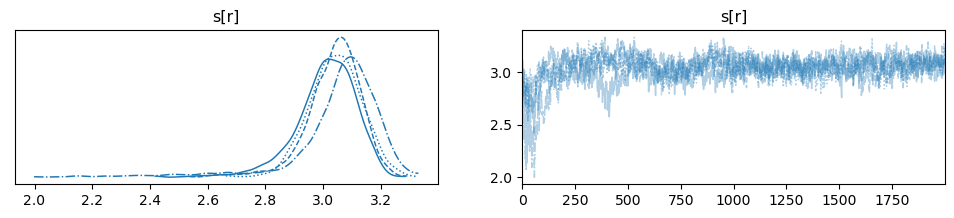

In [18]:
az.plot_trace(idata['s[r]'])

/home/hylke/.local/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>]], dtype=object)

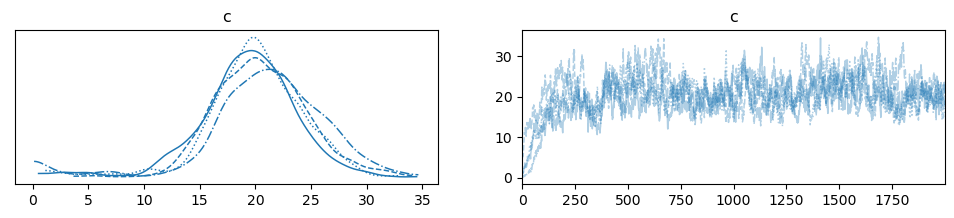

In [12]:
az.plot_trace(idata['c'])